In [ ]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing import image
from collections import  Counter
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
workspace_path = '/gdrive/My Drive/' 
data_path = os.path.join(workspace_path, 'data')  #데이터 경로 설정 (workspace_path 이용한 경로 설정)

In [ ]:
train = pd.read_csv(os.path.join(data_path, 'train.csv'), index_col = 0)
print(train.shape)
pd.set_option('max_colwidth', 150)
train.head()

(54879, 2)


,text,author
index,,
0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixe...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in sp...",1
3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “...",4
4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you ...",3


In [ ]:
test = pd.read_csv(os.path.join(data_path, 'test_x.csv'), index_col = 0)
print(test.shape)
pd.set_option('max_colwidth', 150)
test.head()

(19617, 1)


,text
index,
0,"“Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. ..."
1,"""No,"" replied he, with sudden consciousness, ""not to find it in YOU; for I cannot be ignorant that to you, to your goodness, I owe it all.--I feel..."
2,"As the lady had stated her intention of screaming, of course she would have screamed at this additional boldness, but that the exertion was render..."
3,“And then suddenly in the silence I heard a sound which sent my heart into my mouth. It was the clank of the levers and the swish of the leaking c...
4,"His conviction remained unchanged. So far as I know--and I believe his honest heart was transparent to me--he never wavered again, in his solemn c..."


##train data 분포 확인하기

### 1)작가별 건수

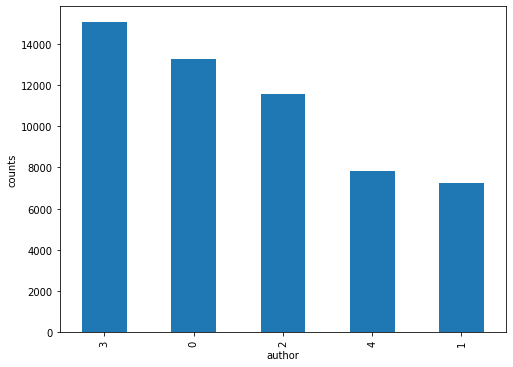

In [ ]:
plt.figure(figsize = (8,6)) # 작가별 건 수 (균등하게 배분되지 않고 3번과 0번 작가의 건수가 많습니다.)
plt.xlabel('author')
plt.ylabel('counts')
train['author'].value_counts().plot(kind='bar')

### 2)문자 길이 분포

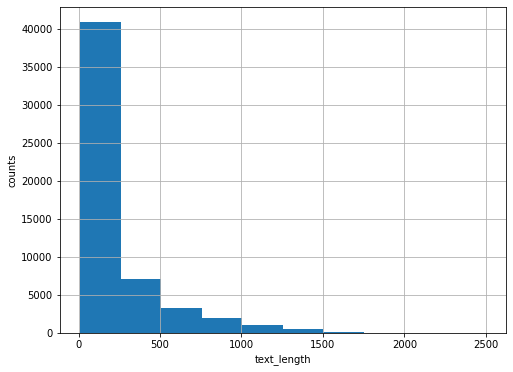

In [ ]:
plt.figure(figsize = (8,6)) #문자 길이는 대략 2000자 ~ 2500자 정도까지 있으며 일반적으로 0~500사이에 많이 분포 특히, 0~250자의 데이터가 대부분
plt.xlabel('text_length')
plt.ylabel('counts')
train['text'].str.len().hist()

### 3)average word length (평균 단어 길이)

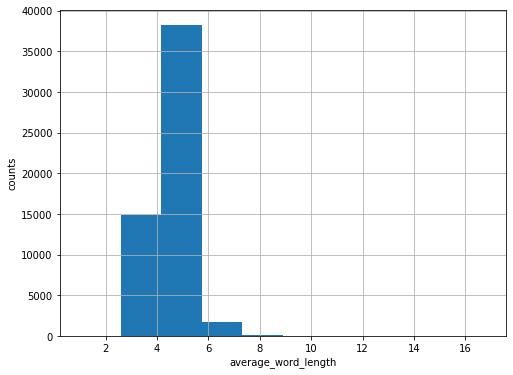

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('average_word_length')
plt.ylabel('counts')
train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [ ]:
fig = plt.figure(figsize=(25,12)) 

def plot_top_stopwords_barchart(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]    
    x,y=zip(*top)  
    return x, y

for i in range(5):
    x,y = plot_top_stopwords_barchart(train[train['author']==i]['text'])    # rows*cols 행렬의 i번째 subplot 생성
    ax = fig.add_subplot(2, 3, i+1)  # 2,3 형태로 그래프 표현
    ax.set_title(i, fontsize=20)
    ax.barh(x,y)  #가로 막대 그래프 
    ax.set_yticklabels(x, fontsize=15) #y축 불용어들 크기 설정
    plt.xticks(fontsize=12) #x축 숫자들 크기 설정

평균 단어 길이는 2\~9자이며 4\~6자가 가장 많음을 알 수 있습니다. 그렇다면 '이 길이가 가장 많이 쓰고 있는 단어의 글자 수 이다.' 라고 말할 수 있을까요?     그렇지 않습니다.  
이유는 여러가지가 있지만 그 중 하나가 불용어 때문입니다. 불용어는 모든 언어에서 가장 일반적으로 쓰이는 것으로 영어에서 예시를 들면 "the", "a", "an"등이 해당됩니다. 


#불용어(stop word) 확인해보기


In [ ]:
import nltk 
from nltk.corpus import stopwords #필요한 nltk 라이브러리 가져오기 

nltk.download('stopwords')   #불용어 부분만 다운 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop=set(stopwords.words('english'))

###1) train data 전체 불용어 

<BarContainer object of 10 artists>

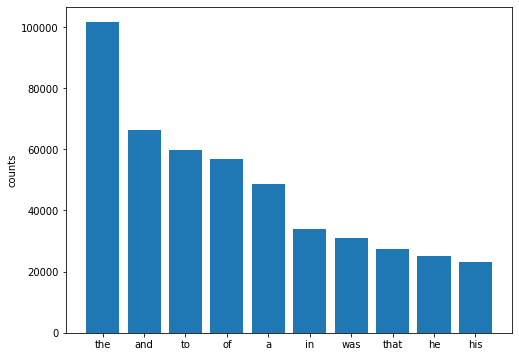

In [ ]:
corpus=[]
new = train['text'].str.split()  #train 데이터 
new = new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.figure(figsize=(8,6))
plt.ylabel('counts')
plt.bar(x,y)

### 2)작가 별 불용어 상위 10개




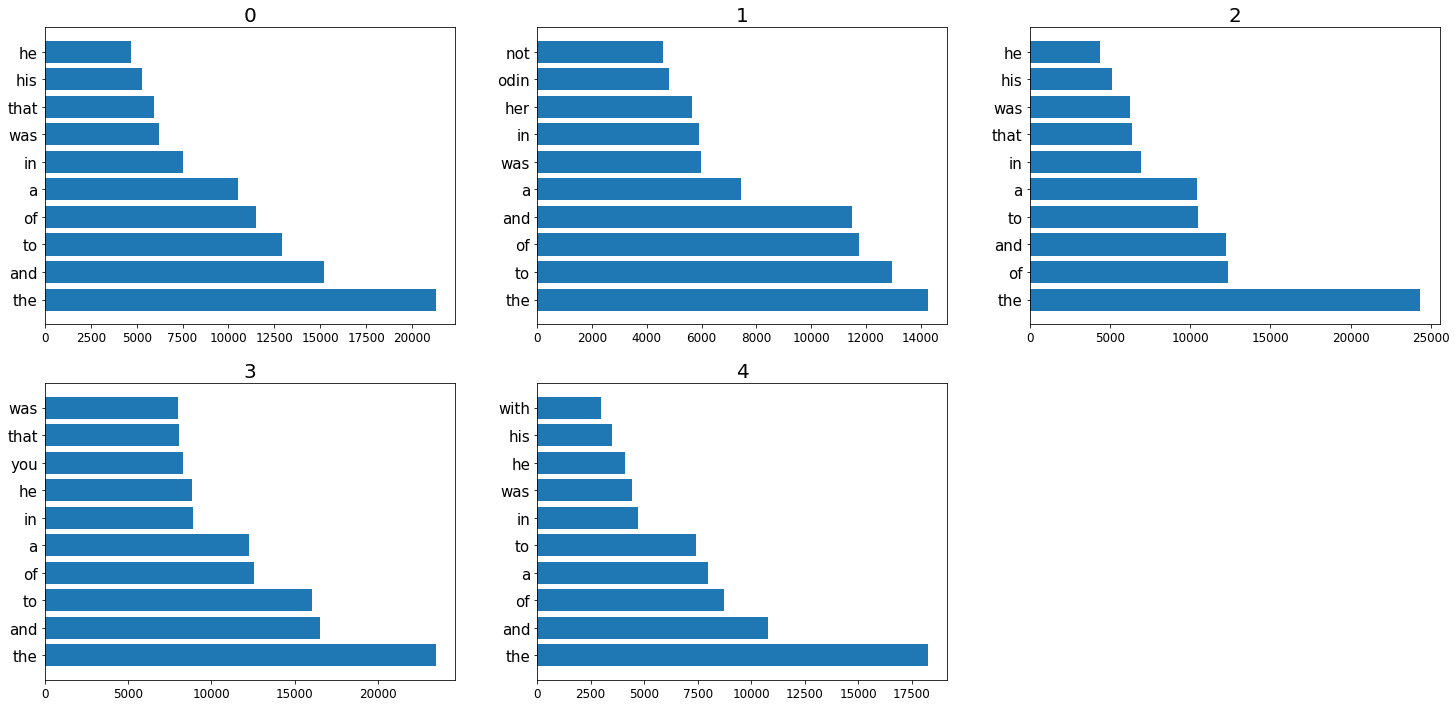

In [ ]:
fig = plt.figure(figsize=(25,12)) 

def top10_stopwords(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]   
    x,y=zip(*top)  
    return x, y

for i in range(5):
    x,y = top10_stopwords(train[train['author']==i]['text'])    # rows*cols 행렬의 i번째 subplot 생성
    ax = fig.add_subplot(2, 3, i+1)  # 2,3 형태로 그래프 표현
    ax.set_title(i, fontsize=20)
    ax.barh(x,y)  #가로 막대 그래프 
    ax.set_yticklabels(x, fontsize=15) #y축 불용어들 크기 설정
    plt.xticks(fontsize=12) #x축 숫자들 크기 설정

동일선상에 놓고 단어들을 비교하고 싶어 가로 막대 그래프로 출력하였습니다.  
작가 별로 불용어 개수도 the가 가장 많다는 공통점을 제외하고는 다른 상황입니다. 원래는 불용어 처리를 해주지만 여기서는 이것 또한 의미있는 특성이 될 것 같습니다. 따라서 'the' 제외한 단어는 삭제하지 않도록 하겠습니다.

#불용어가 아닌 값 확인하기  
불용어 외에도 의미 없는 데이터가 존재할 것 같아 시각화를 통해 확인을 해보았습니다. 

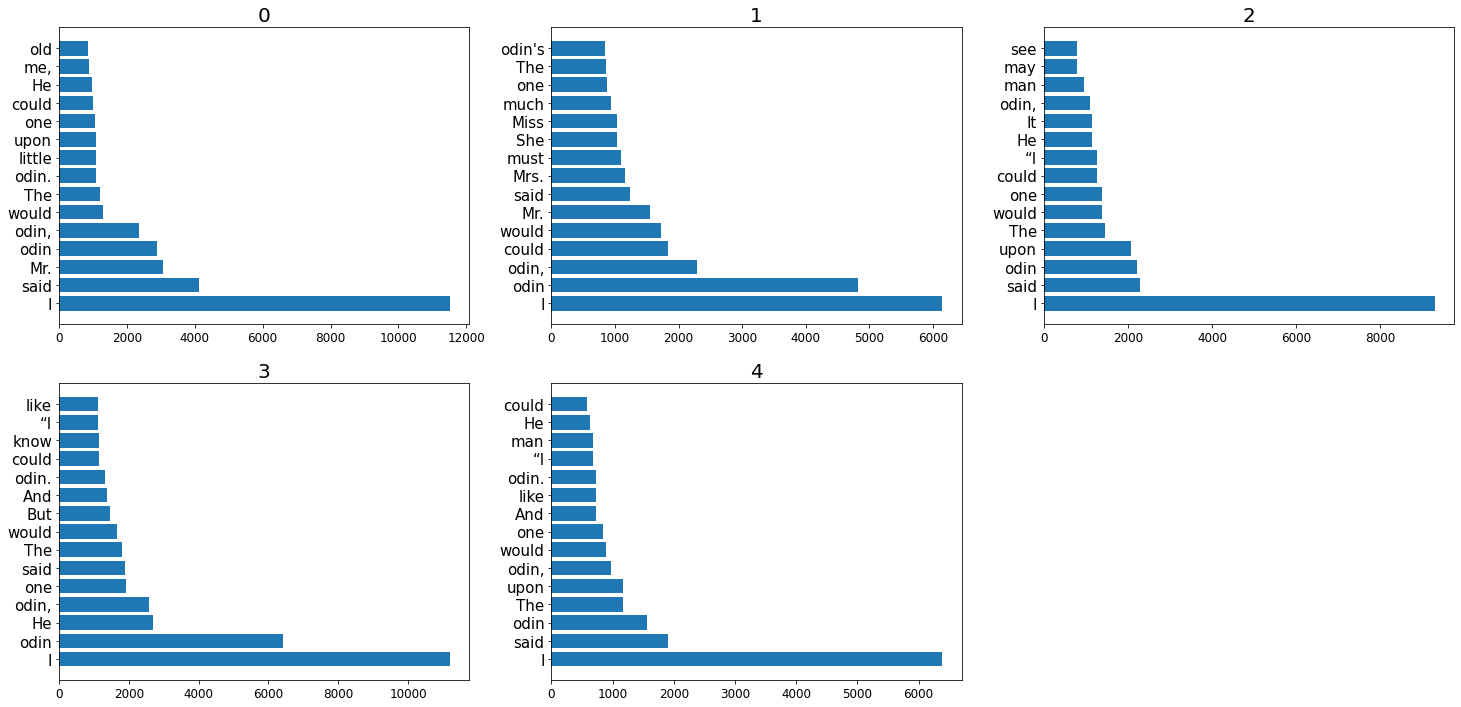

In [ ]:
fig = plt.figure(figsize=(25,12)) 

def top15_non_stopwords(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    dic=defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15]   
    x,y=zip(*top)  
    return x, y

for i in range(5):
    x,y = top15_non_stopwords(train[train['author']==i]['text'])    # rows*cols 행렬의 i번째 subplot 생성
    ax = fig.add_subplot(2, 3, i+1)  # 2,3 형태로 그래프 표현
    ax.set_title(i, fontsize=20)
    ax.barh(x,y)  #가로 막대 그래프 
    ax.set_yticklabels(x, fontsize=15) #y축 불용어들 크기 설정
    plt.xticks(fontsize=12) #x축 숫자들 크기 설정

불용어가 아닌 값들 역시 처리가 필요할 것 같습니다. 'odin', 'said'와 같이 의미없어보이는 데이터가 존재했기 때문입니다. odin은 아마 사람 이름이 odin으로 처리된 것 같은데 모든 작가에 포함이 되어있고 의미가 없을 것 같아 제거하기로 결정했습니다.  
  

이외에도 I나 He, She와 같은 값이 존재했는데 어차피 저는 'the'를 제외한 불용어에 존재하는 값들이 의미있어 보여서 새로 만들어 처리할 예정이었습니다. 따라서 이는 처리를 끝낸 뒤 다시 시각화를 해서 데이터 정보를 보고 판단해야할 것 같았습니다. 

#데이터 전처리

### 1) 데이터를 함께 처리하기 위해 train과 test 합쳐주기 

In [ ]:
data = pd.concat([train, test])    #데이터 합치기 
print(data.shape)
data

(74496, 2)


,text,author
index,,
0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixe...",3.0
1,"“Your sister asked for it, I suppose?”",2.0
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in sp...",1.0
3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “...",4.0
4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you ...",3.0
...,...,...
19612,"At the end of another day or two, odin growing visibly stronger every twelve hours, Mrs. odin, urged equally by her own and her daughter's wishes,...",NaN
19613,"All afternoon we sat together, mostly in silence, watching my lord’s door. My own mind was busy with the scene that had just passed, and its singu...",NaN
19614,"odin, having carried his thanks to odin, proceeded with his happiness to Lucy; and such was the excess of it by the time he reached Bartlett's Bu...",NaN


### 2)소문자 처리 추가
같은 단어임에도 다르게 인식할 가능성이 있기때문에 처리를 해주었습니다. 

In [ ]:
data['text'] = data['text'].str.lower()  #소문자 처리 

### 3) 불용어 처리
앞서 'the', 'said', 'odin'관련된 값들을 제외하고는 넣기로 판단하였으니 새로 stopwords 집합을 만들어 처리를 해주어야합니다. 

In [ ]:
#특수 문자 제거함수 
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)   #맨 처음 데이터 전처리 때는 포함 시켰습니다. 

# 불용어 제거해주는 함수 (새로 정의)
def rm_stopwords(text):
    text_tr = []
    for i in text.split():
        if i.strip().lower() not in stopwords_new:
            text_tr.append(i.strip())
    return " ".join(text_tr)

#불용어 만들기
stopwords_new = ['the', 'said', 'odin', 'odin\'s', 'odin,' 'odin.']   #위에서 추정한 바와 같이 나만의 불용어를 만들고 이를 토대로 함수를 정의하여 사용하였습니다. 

#data['text'] = data['text'].apply(alpha_num).apply(rm_stopwords)  #맨 처음 데이터 전처리 때는 포함 시켰습니다. 그러나 특수문자도 작가마다 얼마나 많이 썼는지 
                                                                   #같은 길이의 책을 써도 문장을 짧게 썼는지에 따라 개수가 차이나고 의미 있는 데이터가 될 수 있어 포함시켰습니다. 

data['text'] = data['text'].apply(rm_stopwords)    #제거 함수 적용 

In [ ]:
data   #잘 처리가 되었는 지 확인 

,text,author
index,,
0,"he was almost choking. there was so much, so much he wanted to say, but strange exclamations were all that came from his lips. pole gazed fixedly ...",3.0
1,"“your sister asked for it, i suppose?”",2.0
2,"she was engaged one day as she walked, in perusing jane’s last letter, and dwelling on some passages which proved that jane had not written in spi...",1.0
3,"captain was in porch, keeping himself carefully out of way of a treacherous shot, should any be intended. he turned and spoke to us, “doctor's wat...",4.0
4,"“have mercy, gentlemen!” flung up his hands. “don’t write that, anyway; have some shame. here i’ve torn my heart asunder before you, and you seize...",3.0
...,...,...
19612,"at end of another day or two, growing visibly stronger every twelve hours, mrs. odin, urged equally by her own and her daughter's wishes, began to...",NaN
19613,"all afternoon we sat together, mostly in silence, watching my lord’s door. my own mind was busy with scene that had just passed, and its singular ...",NaN
19614,"odin, having carried his thanks to odin, proceeded with his happiness to lucy; and such was excess of it by time he reached bartlett's buildings, ...",NaN


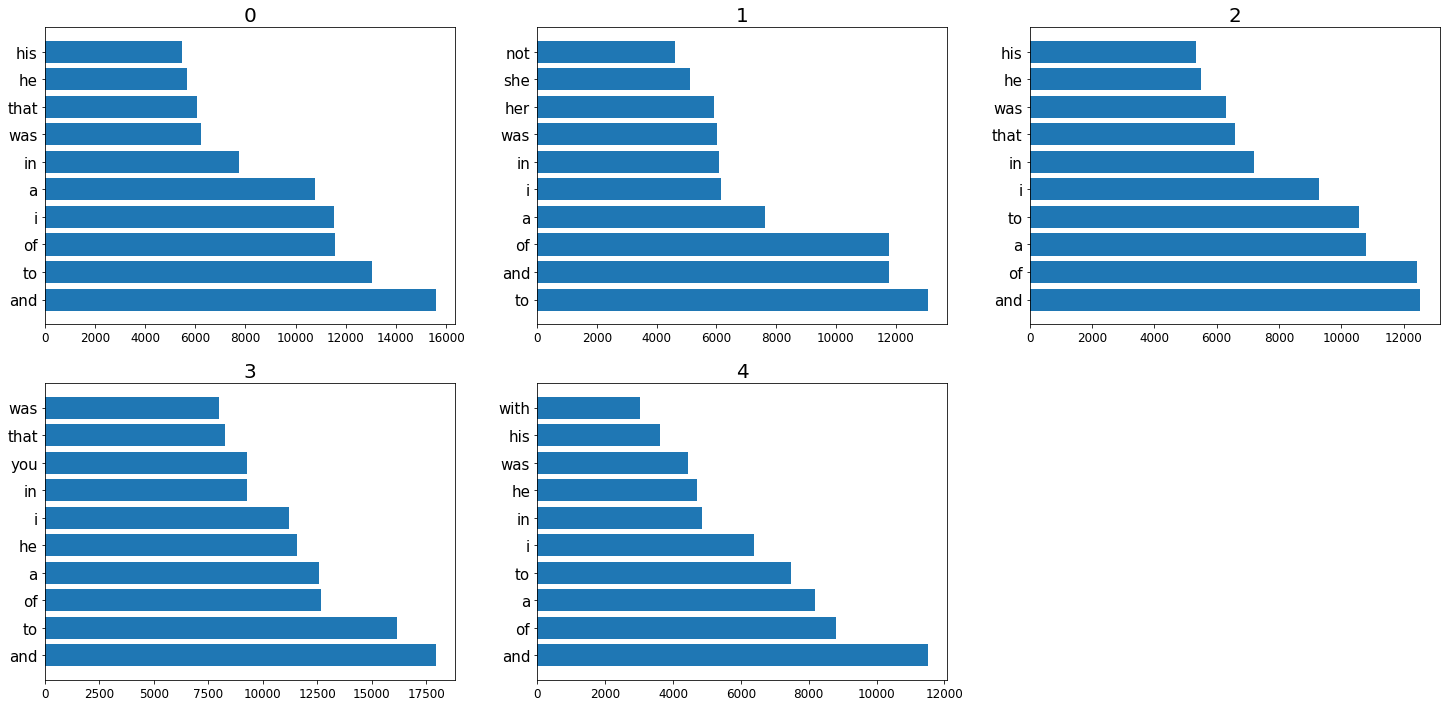

In [ ]:
fig = plt.figure(figsize=(25,12)) 

def after_processing_stopwords_new_top10(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    dic=defaultdict(int)
    for word in corpus:
        dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = after_processing_stopwords_new_top10(data[data['author']==i]['text'])
    ax = fig.add_subplot(2, 3, i+1) 
    ax.set_title(i, fontsize=20)
    ax.barh(x,y)
    ax.set_yticklabels(x, fontsize=15)
    plt.xticks(fontsize=12) 

처리를 하고 나서 보니 전치사와 대명사 정도는 처리를 해줘야할 것 같다는 생각이 들어 다시 불용어 처리를 진행했습니다. 

In [ ]:
def rm_stopwords_r(text):
    text_tr = []
    for i in text.split():
        if i.strip().lower() not in stopwords_new_r:
            text_tr.append(i.strip())
    return " ".join(text_tr)

#불용어 만들기
stopwords_new_r = ['the', 'said', 'odin', 'odin\'s', 'odin,', 'odin.','and', 'of', 'to', 'in', 'on', 'at', 'from', 'with', 'a', 'i', 'you', 'he', 'she']

data['text'] = data['text'].apply(rm_stopwords_r)

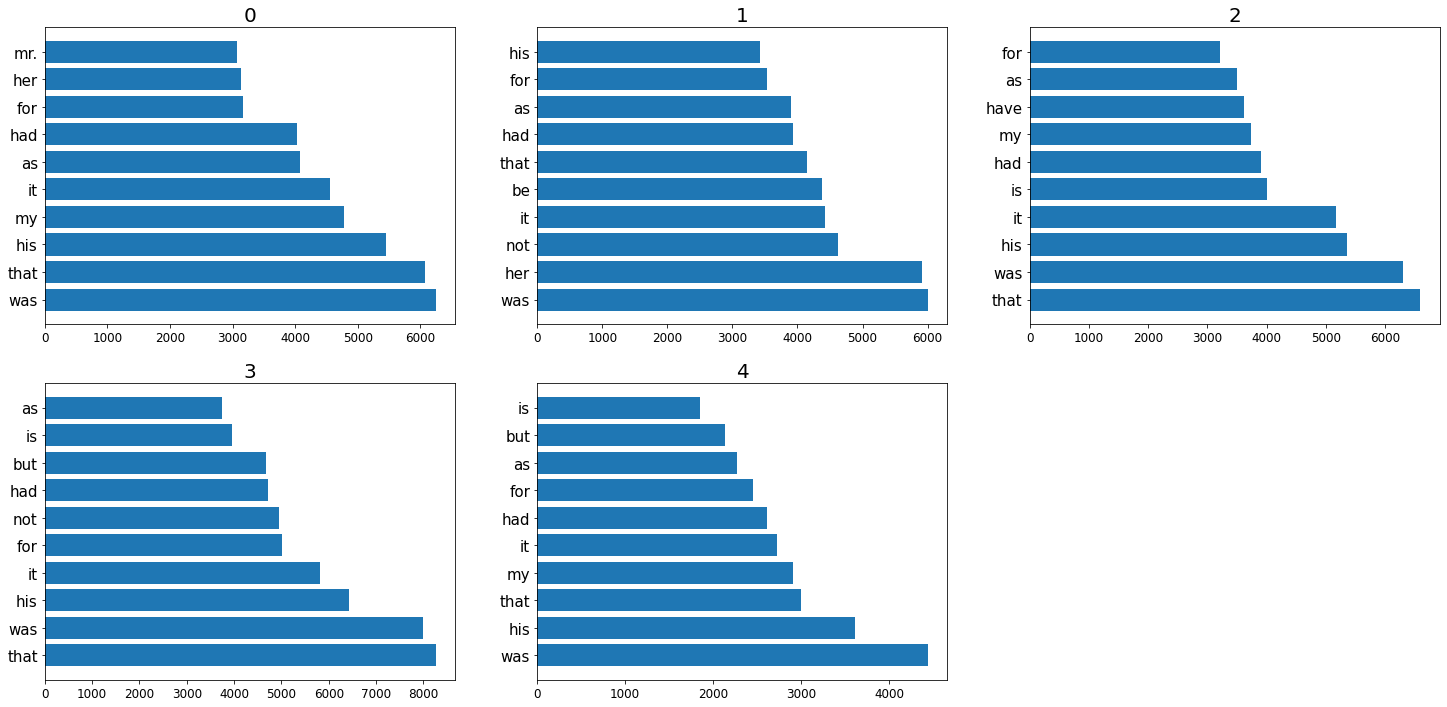

In [ ]:
fig = plt.figure(figsize=(25,12)) 

def after_processing_stopwords_ver2_new_top10(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = after_processing_stopwords_ver2_new_top10(data[data['author']==i]['text'])
    ax = fig.add_subplot(2, 3, i+1) 
    ax.set_title(i, fontsize=20)
    ax.barh(x,y)
    ax.set_yticklabels(x, fontsize=15)
    plt.xticks(fontsize=12) 

한 문장에 포함된 최대 단어 개수 : 340 
한 문장에 포함된 최소 단어 개수 : 1
index
0         32
1          6
2         42
3         39
4         32
        ... 
19612    106
19613    195
19614     40
19615     48
19616     84
Name: number_of_words, Length: 74496, dtype: int64


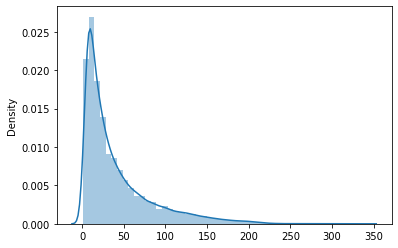

In [ ]:
data_1 = data.copy()  #길이를 확인하고자 복사하여 사용 추후 데이터 삭제하기 싫어서 사용하였습니다. 

data_1['number_of_words'] = data_1.text.apply(lambda words: len(words.split()))  #한 문장에 들어가는 단어의 개수를 만들고 그래프로 그려보았습니다. 
print(f"한 문장에 포함된 최대 단어 개수 : {data_1['number_of_words'].max()} \n한 문장에 포함된 최소 단어 개수 : {data_1['number_of_words'].min()}") #최소 단어 개수와 최대 단어 개수를 출력해보았습니다. 
print(data_1['number_of_words'])
sns.distplot(tuple(data_1['number_of_words']), hist=True, kde=True)

추후 모델링에서 적용할 최대 길이(max_length)는 200정도(거의 대부분의 데이터가 들어가는 부분)로 잡아주면 될 것 같습니다. 

In [ ]:
train_data = data[:len(train)]  #concat으로 합쳤던 train과 test를 다시 나눠줍니다. train의 길이로 슬라이싱을 해주면 됩니다. 
test_data = data[len(train):]
train_data.shape, test_data.shape 

((54879, 2), (19617, 2))

여기까지 데이터 전처리 진행을 하고 베이스라인과 동일한 모델을 돌려 점수를 얻었으나 베이스 라인 점수보다 낮은 스코어를 획득해 잘못되었음을 깨닫고 전체적으로 단어의 분포를 다시 보고자 워드 클라우드를 진행해보았다. 
#워드클라우드
불용어 처리의 필요성을 깨닫게 되는 시각화였습니다.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter
from functools import reduce

from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
wc_text = np.array([x for x in train_data['text']])
wc_text

array(['was almost choking. there was so much, so much wanted say, but strange exclamations were all that came his lips. pole gazed fixedly him, bundle notes his hand; looked was evident perplexity.',
       '“your sister asked for it, suppose?”',
       'was engaged one day as walked, perusing jane’s last letter, dwelling some passages which proved that jane had not written spirits, when, instead being again surprised by mr. saw looking up that was meeting her. putting away letter immediately forcing smile, said:',
       ..., '"your sincere well-wisher, friend, sister, "lucy',
       '“then wanted me lend money?”',
       'it certainly had not occurred me before, but said, yes, should like that.'],
      dtype='<U2041')

In [ ]:
lemma = WordNetLemmatizer()
words_1 = []

for tr_text in wc_text:
  EnWords = re.sub(r"[^a-zA-Z]+", " ", str(wc_text))
  EnWordsToken = word_tokenize(EnWords.lower())
  EnWordsTokenStop = [w for w in EnWordsToken]
  EnwordsTokenStopLemma = [lemma.lemmatize(w) for w in EnWordsTokenStop]
  words_1.append(EnwordsTokenStopLemma)


In [ ]:
words_2 = list(reduce(lambda x,y : x+y, words_1))   #  불용어 처리를 안 해줘서 많은 단어가 포함되어 있어 1차원으로 펼치는 데만 46~47분 정도 소요됩니다.

In [ ]:
wc_count = Counter(words_2)

In [ ]:
wc_word_count = dict()

for tag, counts in wc_count.most_common(50):
    if(len(str(tag))>1):
        wc_word_count[tag] = counts

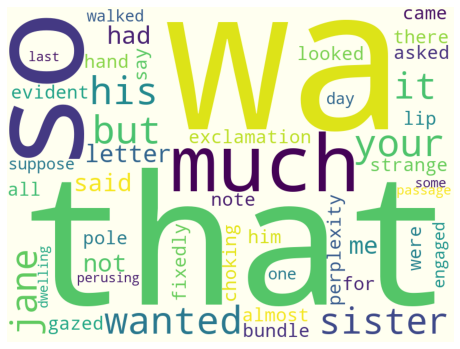

In [ ]:
wc=WordCloud(background_color='ivory', width=800, height=600)
cloud=wc.generate_from_frequencies(wc_word_count)

plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

워드클라우드를 보고 불용어가 처리되어야만 모델의 성능이 잘 나올 것 같다는 생각이 들었습니다. that이나 so 각종 인칭대명사을 지워주어야 작가별로 의미 있는 단어들이 보이기 시작할 것 같습니다.. 
#다시 불용어처리
앞서 사용했던 불용어 라이브러리([해당부분으로가기](https://colab.research.google.com/drive/16E8JeRvBPpfQ0lrWEvxUUTJu6EVd0nBy#scrollTo=aMhwQiXzMOsV&line=2&uniqifier=1))로 처리하고 필요한 값을 추가하여 처리하겠습니다. 일반적으로 쓰이는 동사나 전치사 대명사들이 모두 포함된 라이브러리이므로 앞서 불용어 외에 처리하고자 하였던 odin이나 said, 워드클라우드에서 추가로 확인한 wa를 stop 집합에 추가하여 사용하도록 하겠습니다.

In [ ]:
stop.update(('said', 'odin', 'odin\'s', 'odin,', 'odin.', 'wa'))

In [ ]:
#불용어 처리 다시 정의 
def rm_stopwords_re(text):
    text_tr = []
    for i in text.split():
        if i.strip().lower() not in stop:
            text_tr.append(i.strip())
    return " ".join(text_tr)

In [ ]:
data['text'] = data['text'].apply(rm_stopwords_re)

In [ ]:
data

,text,author
index,,
0,"almost choking. much, much wanted say, strange exclamations came lips. pole gazed fixedly him, bundle notes hand; looked evident perplexity.",3.0
1,"“your sister asked it, suppose?”",2.0
2,"engaged one day walked, perusing jane’s last letter, dwelling passages proved jane written spirits, when, instead surprised mr. saw looking meetin...",1.0
3,"captain porch, keeping carefully way treacherous shot, intended. turned spoke us, “doctor's watch lookout. dr. take north side, please; jim, east;...",4.0
4,"“have mercy, gentlemen!” flung hands. “don’t write that, anyway; shame. i’ve torn heart asunder you, seize opportunity fingering wounds halves.......",3.0
...,...,...
19612,"end another day two, growing visibly stronger every twelve hours, mrs. urged equally daughter's wishes, began talk removing measures depended two ...",NaN
19613,"afternoon sat together, mostly silence, watching lord’s door. mind busy scene passed, singular resemblance vision. must say word upon this, story ...",NaN
19614,"carried thanks proceeded happiness lucy; excess time reached bartlett's buildings, able assure mrs. called next day congratulations, never seen sp...",NaN


In [ ]:
train_data = data[:len(train)]  #위에서 부터 진행했던 방식과 똑같이 다시 진행해줍니다. 
test_data = data[len(train):]
train_data.shape, test_data.shape 

((54879, 2), (19617, 2))

#Vectorization
### 1)Tokenization

In [ ]:
# 먼저 train 데이터와 test 데이터 인덱스 없이 배열로 만들기
x_train = np.array([x for x in train_data['text']])
x_test = np.array([x for x in test_data['text']])
y_train = np.array([x for x in train_data['author']])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(54879,)
(19617,)
(54879,)


In [ ]:
print(x_train)
print(x_test)
print(y_train)

['almost choking. much, much wanted say, strange exclamations came lips. pole gazed fixedly him, bundle notes hand; looked evident perplexity.'
 '“your sister asked it, suppose?”'
 'engaged one day walked, perusing jane’s last letter, dwelling passages proved jane written spirits, when, instead surprised mr. saw looking meeting her. putting away letter immediately forcing smile, said:'
 ... '"your sincere well-wisher, friend, sister, "lucy'
 '“then wanted lend money?”'
 'certainly occurred before, said, yes, like that.']
['“not all. think one charming young ladies ever met, might useful work doing. decided genius way: witness way preserved agra plan papers father. love emotional thing, whatever emotional opposed true cold reason place things. never marry myself, lest bias judgment.”'
 '"no," replied he, sudden consciousness, "not find you; cannot ignorant you, goodness, owe all.--i feel it--i would express could--but, well know, orator."'
 'lady stated intention screaming, course would

#Modeling
### NLP

In [ ]:
#파라미터 설정
vocab_size = 20000 #보통 많이 쓰이는 값이라고 합니다.
embedding_dim = 16
max_length = 200  #앞서 결정한 max_length 값으로 설정했습니다. (문장에 단어 몇 개 포함되어 있는지에 대한 그래프)
padding_type='post'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
import tensorflow as tf
#가벼운 NLP모델 생성
model_n = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# compile model
model_n.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_n.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 16)           320000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 125       
Total params: 320,533
Trainable params: 320,533
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow import keras
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h1')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [ ]:
# fit model
num_epochs = 25
history = model_n.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2,callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/25
1372/1372 - 6s - loss: 1.4995 - accuracy: 0.3492 - val_loss: 1.2886 - val_accuracy: 0.5330
INFO:tensorflow:Assets written to: best-model.h1/assets
Epoch 2/25
1372/1372 - 5s - loss: 1.0798 - accuracy: 0.5872 - val_loss: 0.9767 - val_accuracy: 0.6213
INFO:tensorflow:Assets written to: best-model.h1/assets
Epoch 3/25
1372/1372 - 5s - loss: 0.8647 - accuracy: 0.6808 - val_loss: 0.8544 - val_accuracy: 0.6816
INFO:tensorflow:Assets written to: best-model.h1/assets
Epoch 4/25
1372/1372 - 5s - loss: 0.7469 - accuracy: 0.7289 - val_loss: 0.7979 - val_accuracy: 0.7032
INFO:tensorflow:Assets written to: best-model.h1/assets
Epoch 5/25
1372/1372 - 5s - loss: 0.6632 - accuracy: 0.7646 - val_loss: 0.7588 - val_accuracy: 0.7151
INFO:tensorflow:Assets written to: best-model.h1/assets
Epoch 6/25
1372/1372 - 5s - loss: 0.5977 - accuracy: 0.7896 - val_loss: 0.7208 - val_accuracy: 0.7380
INFO:tensorflow:Assets written to: best-model.h1/assets
Epoch 7/25
1372/1372 - 5s - loss: 0.5450 - accuracy:

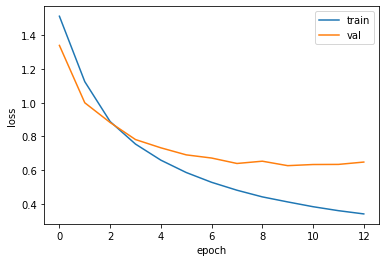

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
pred_y = model_n.predict_proba(test_padded)

In [ ]:
pred_y

array([[1.40249875e-04, 9.54210997e-01, 2.08020732e-02, 2.48088017e-02,
        3.78443110e-05],
       [1.18759172e-02, 9.38254595e-01, 1.42728221e-02, 7.89992325e-03,
        2.76968889e-02],
       [9.97026742e-01, 1.27427932e-03, 6.65323387e-06, 4.47304456e-06,
        1.68784382e-03],
       ...,
       [3.69917107e-04, 9.99600589e-01, 3.57564318e-06, 2.41749276e-05,
        1.83040277e-06],
       [1.43631711e-04, 9.99827325e-01, 1.41175096e-05, 1.35087812e-05,
        1.58279022e-06],
       [9.82534587e-01, 2.14525047e-04, 1.10691726e-04, 3.91405592e-05,
        1.71011034e-02]], dtype=float32)

In [ ]:
sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), index_col = 0)

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = pred_y
sample_submission

,0,1,2,3,4
index,,,,,
0,0.000140,9.542110e-01,2.080207e-02,2.480880e-02,3.784431e-05
1,0.011876,9.382546e-01,1.427282e-02,7.899923e-03,2.769689e-02
2,0.997027,1.274279e-03,6.653234e-06,4.473045e-06,1.687844e-03
3,0.000037,5.160171e-09,9.925948e-01,1.231171e-07,7.368140e-03
4,0.903141,3.475137e-02,1.516220e-04,5.614134e-02,5.814746e-03
...,...,...,...,...,...
19612,0.000013,9.999870e-01,1.637595e-12,9.054094e-11,1.322887e-11
19613,0.085560,2.123468e-08,2.870951e-05,9.179063e-09,9.144116e-01
19614,0.000370,9.996006e-01,3.575643e-06,2.417493e-05,1.830403e-06


In [ ]:
sample_submission.to_csv(os.path.join(data_path, 'submission_why.csv'))